# Analyzing Marketing Campaigns

In this project I'll try to analyze how different marketing channels are performing.

**Questions:** 
How different marketing channels are performing?
Is there a problem about campaigns? 

## 1. Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Loading the dataset and taking a quick look

In [2]:
marketing = pd.read_csv('marketing_ds_1.csv', parse_dates=['date_served',
                                                      'date_subscribed', 
                                                      'date_canceled'])

In [3]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              10037 non-null  object        
 1   date_served          10021 non-null  datetime64[ns]
 2   marketing_channel    10022 non-null  object        
 3   variant              10037 non-null  object        
 4   converted            10022 non-null  object        
 5   language_displayed   10037 non-null  object        
 6   language_preferred   10037 non-null  object        
 7   age_group            10037 non-null  object        
 8   date_subscribed      1856 non-null   datetime64[ns]
 9   date_canceled        577 non-null    datetime64[ns]
 10  subscribing_channel  1856 non-null   object        
 11  is_retained          1856 non-null   object        
dtypes: datetime64[ns](3), object(9)
memory usage: 941.1+ KB


## 3. Preprocessing before analysis

In [4]:
# A new column for retention
marketing["is_retained"] = np.where(marketing["converted"] == False, 0,
                                    marketing["is_retained"].values)

marketing['converted'] = marketing["converted"].astype("bool")
marketing['is_retained'] = marketing["is_retained"].astype("bool")

# Strings to numbers for better data storage
marketing.groupby("subscribing_channel")["subscribing_channel"].count()

channel_dict = {"House Ads": 1, "Instagram": 2, "Facebook": 3, "Email": 4, "Push": 5}
marketing["channel_code"] = marketing["subscribing_channel"].map(channel_dict)

# New column: which day of the week?
marketing["DoW"] = marketing["date_subscribed"].dt.dayofweek

## 4. Looking for insights 

- **The first question that comes to mind is how many users have we reached via our marketing assets?**  
This is the first step in order to understand the efficiency of marketing efforts.

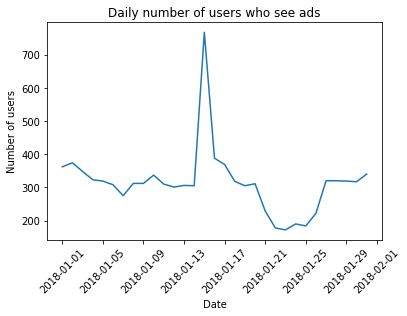

In [5]:
daily_users = marketing.groupby("date_served")["user_id"].nunique()

sns.lineplot(data = daily_users)
plt.title('Daily number of users who see ads') 
plt.xlabel('Date')
plt.ylabel('Number of users') 
plt.tick_params(axis="x", labelsize=10)
plt.xticks(rotation = 45)
plt.show()

- **Marketing channels across age groups**

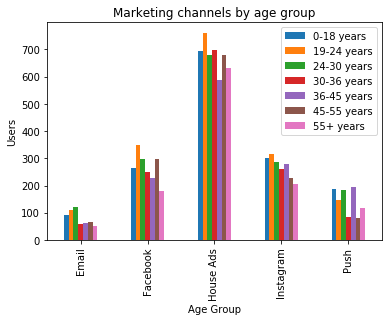

In [6]:
channel_age = marketing.groupby(['marketing_channel', 'age_group'])\
                                ['user_id'].count()

channel_age_df = pd.DataFrame(channel_age.unstack(level = 1))

channel_age_df.plot(kind = 'bar')
plt.title('Marketing channels by age group')
plt.xlabel('Age Group')
plt.ylabel('Users')
plt.legend(loc = 'upper right', 
           labels = channel_age_df.columns.values)
plt.show()

As you can see, 

- Email is not reaching older age groups
- Facebook is not reaching many people under 18
- Instagram is the most effective channel for users between 19-24 years old.

## 5. Marketing Metrics

In [7]:
subscribers = marketing[marketing["converted"] == 1].user_id.nunique()
total = marketing.user_id.nunique()
conv_rate = subscribers / total

retained = marketing[marketing["is_retained"] == 1].user_id.nunique()
retention = retained / subscribers

print("Total conversion rate: ", round(conv_rate*100, 2), "%")
print("Total retention rate: ", round(retention*100, 2), "%")

Total conversion rate:  14.09 %
Total retention rate:  67.57 %


There is no definitive number to reach for conversion and retention rates. Defining a metric as "successful" is totally depends on the team. Here, I only have one month of data. Therefore there is no historical data for comparison.

### 5.1.  Building functions for metrics 

Before going further in the analysis I'll write functions for easier calculation of marketing metrics.

In [27]:
### building a retention function

def retention_rate(dataframe, column_names):
    retained = dataframe[dataframe["is_retained"] == True].\
        groupby(column_names)["user_id"].nunique()
        
    converted = dataframe[dataframe["converted"] == True].\
        groupby(column_names)["user_id"].nunique()
        
    retention_rate = retained / converted
    return retention_rate

### building a plotting function

def plot_ret_rate(dataframe):
    for column in dataframe:
        plt.plot(dataframe.index, dataframe[column])
        plt.title('Daily ' + column + ' retention rate\n', size = 16)
        plt.ylabel('Retention rate (%)', size = 14) 
        plt.xlabel('Date', size = 14)
        plt.xticks(rotation= 45)
        plt.show()

### building conversion_rate function

def conversion_rate(dataframe, column_names):
    conversion = dataframe[dataframe["converted"] == True].groupby(column_names)\
        ["user_id"].nunique()
     
    total = dataframe.groupby(column_names)["user_id"].nunique()
    
    conversion_rate = conversion / total
    return conversion_rate


### building plotting function   

def plot_conv_rate(dataframe):
    for column in dataframe:
        plt.plot(dataframe.index, dataframe[column])
        plt.title('Daily ' + column + ' conversion rate\n', size = 16)
        plt.ylabel('Conversion rate (%)', size = 14) 
        plt.xlabel('Date', size = 14)
        plt.xticks(rotation= 45)
        plt.ylim(0)
        plt.show()

## 6. Insights with marketing metrics

#### Conversion rate for languages

In [9]:
language_conversion_rate = conversion_rate(marketing, "language_displayed")

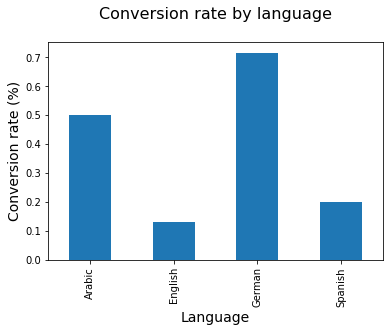

In [10]:
language_conversion_rate.plot(kind = "bar")
plt.title('Conversion rate by language\n', size = 16)
plt.xlabel('Language', size = 14)
plt.ylabel('Conversion rate (%)', size = 14)
plt.show()

This plot shows that German and Arabic speakers have much higher conversion rates than English and Spanish speakers.

#### Daily conversion rate in order to understand trends over time

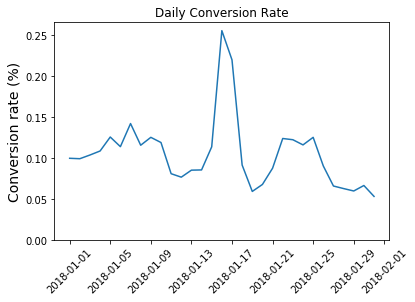

In [11]:
daily_conversion = marketing[marketing["converted"] == True].groupby("date_served")["user_id"].nunique()

daily_conversion_rate = daily_conversion / daily_users

sns.lineplot(data = daily_conversion_rate)
plt.title("Daily Conversion Rate") 
plt.ylabel('Conversion rate (%)', size = 14)
plt.xticks(rotation= 45)
plt.ylim(0)
plt.show()

The conversion rate is relatively steady except for one day in January.

#### Which channel is the best in terms of retention?

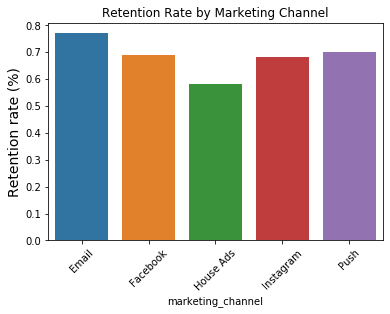

In [12]:
channel_ret = retention_rate(marketing, "marketing_channel")
channel_ret_df = pd.DataFrame(channel_ret).reset_index().rename(columns = {"user_id" : "retention_rate"})

sns.barplot(data = channel_ret_df, x = "marketing_channel", y = "retention_rate")
plt.title("Retention Rate by Marketing Channel") 
plt.ylabel('Retention rate (%)', size = 14)
plt.xticks(rotation= 45)
plt.ylim(0)
plt.show()

Email has a slightly higher retention rate than other channels.  
On the other hand, House Ads has the lowest retention rate.  

#### Conversion rate by date served and age group

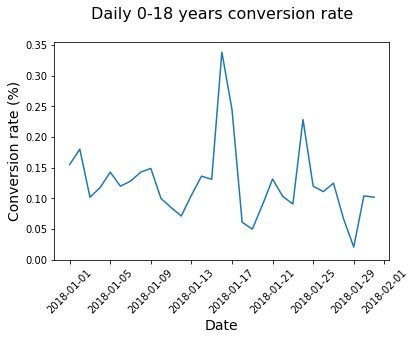

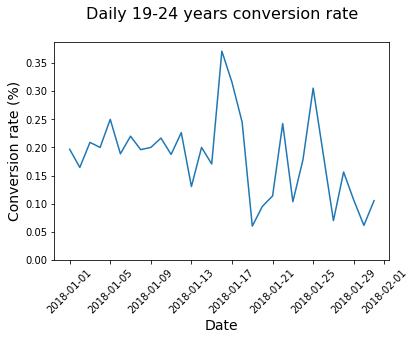

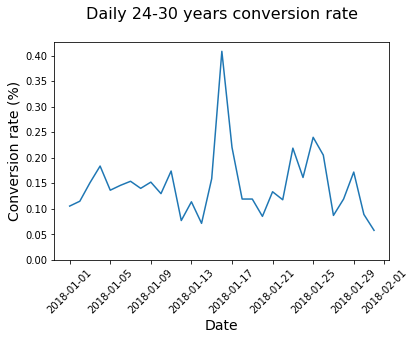

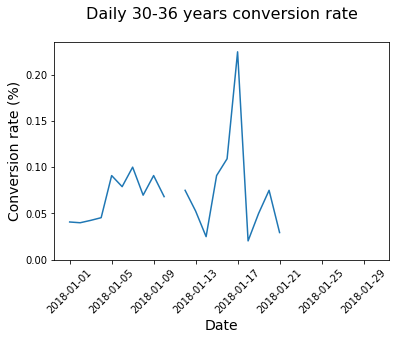

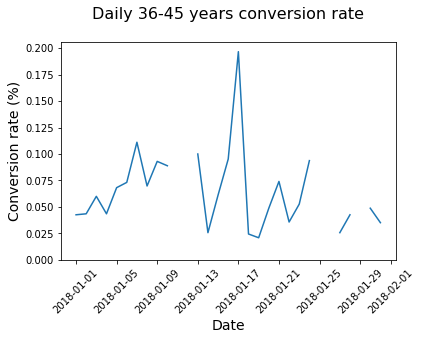

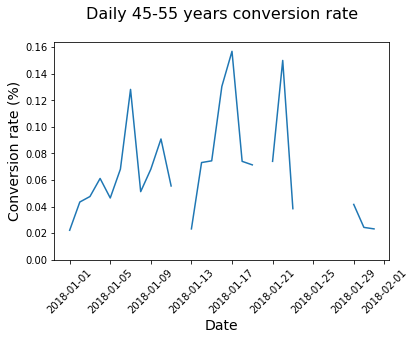

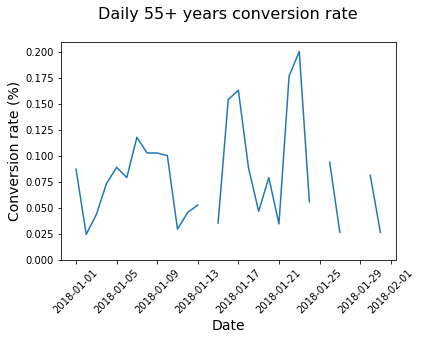

In [28]:
age_group_conv = conversion_rate(marketing, ["date_served", "age_group"])
age_group_df = pd.DataFrame(age_group_conv.unstack(level=1))
plot_conv_rate(age_group_df)

- **Conversion rate by date served and channel**

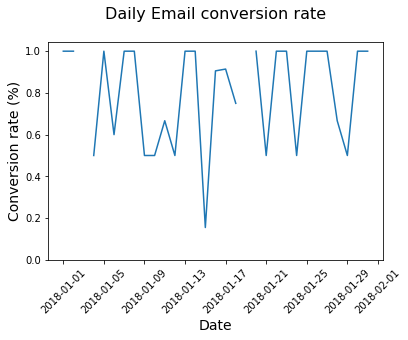

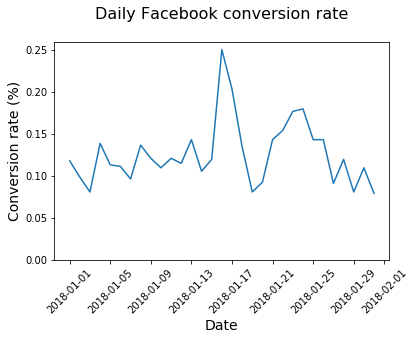

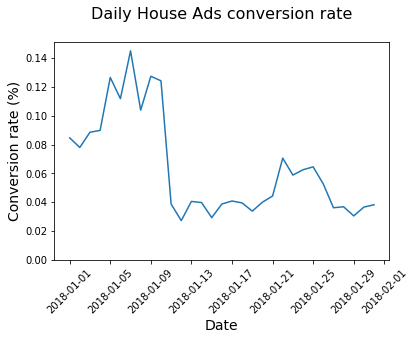

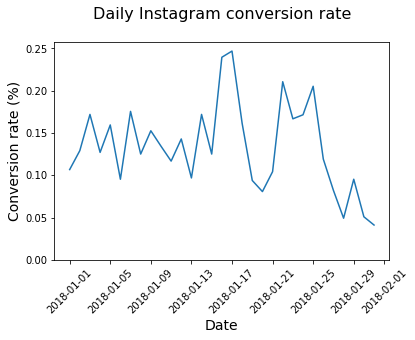

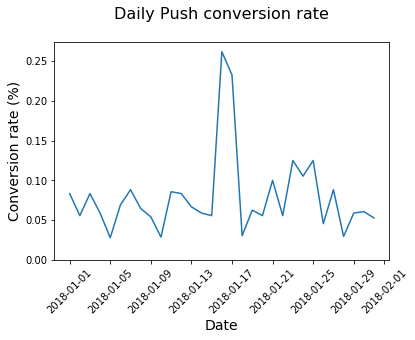

In [29]:
daily_conv_channel = conversion_rate(marketing, ['date_served', 
                                                 'marketing_channel'])

daily_conv_channel = pd.DataFrame(daily_conv_channel.unstack(level = 1))
plot_conv_rate(daily_conv_channel)

There is a sudden decrease in House Ads conversion rate on January 11.  
Also, we'd seen that House Ads has the lowest retention rate compared to other channels.

I'll further investigate why that could be. 

## 7. Searching the issue

There are several possibilities that could cause the problem we've identified above.  
- Is it an expected fluctuation in metrics? (for example; conversion rate differences between the day of the week)  
- Is it a technical problem?
- Or is it a problem about marketing strategy?

#### Could it be an expected fluctuation?

First, I'll check whether there is a difference in conversion rate across the day of the week.

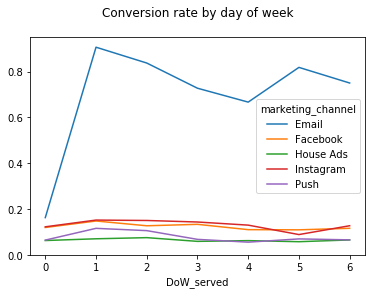

In [15]:
# Creating day of week column
marketing['DoW_served'] = marketing["date_served"].dt.dayofweek

# Calculating conversion rate
DoW_conversion = conversion_rate(marketing, ["DoW_served",'marketing_channel'])
DoW_df = pd.DataFrame(DoW_conversion.unstack(level=1))

# Plotting
DoW_df.plot()
plt.title('Conversion rate by day of week\n')
plt.ylim(0)
plt.show()

Compared to other channels, House ads looks stable across the week except a slight peak on Tuesday. 

This graph shows us the reason for decreasing conversion rate of House Ads is not related to natural fluctuations across the day of the week. 

Note: As you can see, Email is particularly high and may be reflective of another problem to investigate, but one step at a time now. 

#### Could it be a language problem? 

I will take a look at conversion by language over time. Perhaps the House Ads marketing campaign does not equally effective for different cultures.

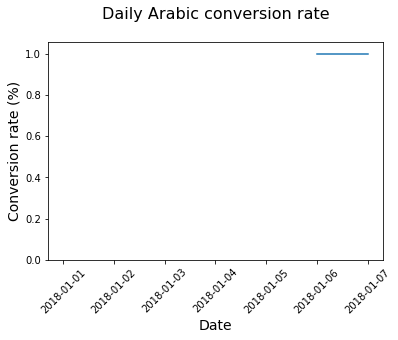

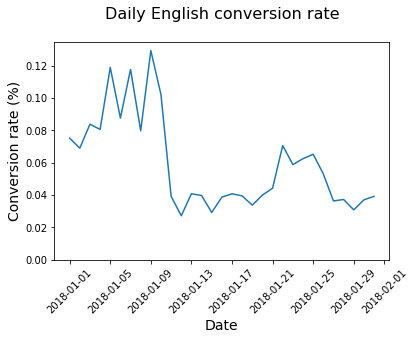

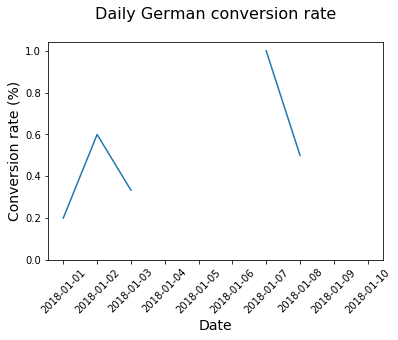

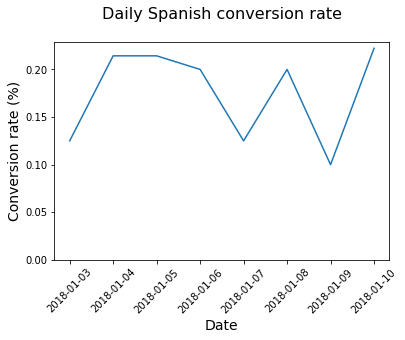

In [30]:
# Isolating House Ads channel
house_ads = marketing[marketing["marketing_channel"] == "House Ads"]

# Calculating conversion rate
conv_lang_channel = conversion_rate(house_ads, ["date_served","language_displayed"])
conv_lang_df = pd.DataFrame(conv_lang_channel.unstack(level=1))

# Plotting
plot_conv_rate(conv_lang_df)

There is a significant decrease in conversion among English-preferred users after 11th. We saw a similar pattern at the total conversion rate of House Ads before.  
Also, there are interruptions for German and Arabic languages. 

By this result, we confirmed that the drop in conversions is related to language preferences.  
In the following steps, we'll clarify the problem.

#### Correct languge and conversion rate relation

/Users/selinalkan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


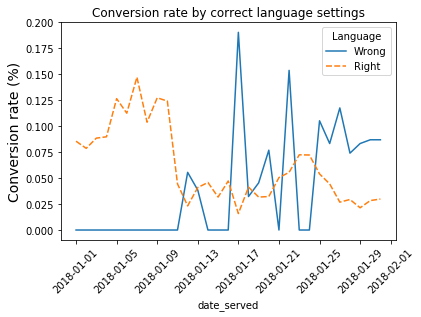

In [17]:
house_ads["is_correct_lang"] = np.where(house_ads["language_displayed"] == house_ads["language_preferred"], "Yes", "No")

lang_check = conversion_rate(house_ads, ["date_served", "is_correct_lang"])
lang_check_df = pd.DataFrame(lang_check.unstack(level = 1)).fillna(0)

sns.lineplot(data = lang_check_df)
plt.title("Conversion rate by correct language settings") 
plt.ylabel('Conversion rate (%)', size = 14)
plt.xticks(rotation= 45)
plt.legend(labels=["Wrong","Right"]\
               ,title="Language")
plt.show()

We can clearly see that there is a problem with the displayed language not being correct. 

#### How many users affected by language problem?

In [18]:
house_ads['is_correct_lang'] = np.where(
    house_ads['language_displayed'] == house_ads['language_preferred'], 
    'Yes', 
    'No')

language_check = house_ads.groupby(["date_served", "is_correct_lang"])["user_id"].count()
language_check_df = pd.DataFrame(language_check.unstack(level=1)).fillna(0)

language_check_df.sum(axis=0)

/Users/selinalkan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


is_correct_lang
No      453.0
Yes    4279.0
dtype: float64

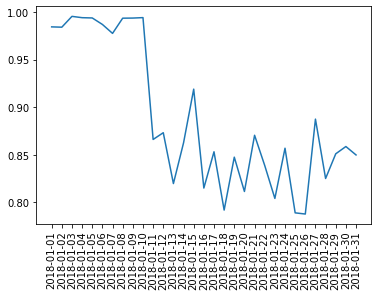

In [32]:
# Percentage of users who saw ads in correct language
language_check_df['pct'] = language_check_df['Yes']/language_check_df.sum(axis=1)
values = pd.period_range(start=min(language_check_df.index.values), 
                               end = max(language_check_df.index.values),
                               freq='D')
# Plotting
plt.plot(language_check_df.index.values, language_check_df['pct'])
plt.xticks(language_check_df.index.values, values,
          rotation = 90)
plt.show()

You have shown that house ads have been underperforming due to serving all ads in other language rather than each user's preferred language.

#### In which language do our users see the ads?

In [20]:
which_lang = marketing[(marketing['date_served'] > "2018-01-10") & (marketing['marketing_channel'] == "House Ads")]
which_lang["is_correct_lang"] = np.where(
    which_lang['language_displayed'] == which_lang['language_preferred'], 
    'Yes', 
    'No')

which_lang_fltrd = which_lang[which_lang["is_correct_lang"] == "No"].groupby(["language_displayed", "language_preferred"])["user_id"].\
nunique()

print(which_lang_fltrd)

language_displayed  language_preferred
English             Arabic                 76
                    German                 62
                    Spanish               218
Spanish             English                 1
Name: user_id, dtype: int64


/Users/selinalkan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


As you can see, most of the users who see the ads in the wrong language, saw them in English.

## 8. Solving the Problem

Now that we've determined that displayed language is the issue with House Ads conversion.

What if we hadn't had this issue? How the daily conversion rate would be?   
and How many new subscribers we would have had?

#### How the daily conversion rate would be?

In [21]:
# Pre-Error conversions by language

# pre-error conversion rate
house_ads_no_bug = house_ads[house_ads["date_served"] < "2018-01-11"]
lang_conv = conversion_rate(house_ads_no_bug, "language_displayed")

# Other language conversion rates against English
spanish_index = lang_conv["Spanish"] / lang_conv["English"]
german_index = lang_conv["German"] / lang_conv["English"]
arabic_index = lang_conv["Arabic"] / lang_conv["English"]


print("Spanish index:", spanish_index)
print("Arabic index:", arabic_index)
print("German index:", german_index)

Spanish index: 1.681924882629108
Arabic index: 5.045774647887324
German index: 4.485133020344287


In [22]:
# Calculating number of converted users
converted = house_ads.groupby(["date_served", "language_preferred"])\
                        .agg({'user_id':'nunique',
                              'converted':'sum'})
converted_df = pd.DataFrame(converted.unstack(level = 1))

converted_df.head()

user_id                        converted                 \
language_preferred  Arabic English German Spanish    Arabic English German   
date_served                                                                  
2018-01-01             2.0   171.0    5.0    11.0       2.0    13.0    1.0   
2018-01-02             3.0   200.0    5.0    10.0       0.0    14.0    3.0   
2018-01-03             2.0   179.0    3.0     8.0       0.0    15.0    1.0   
2018-01-04             2.0   149.0    2.0    14.0       0.0    12.0    0.0   
2018-01-05             NaN   143.0    1.0    14.0       NaN    17.0    0.0   

                            
language_preferred Spanish  
date_served                 
2018-01-01             0.0  
2018-01-02             0.0  
2018-01-03             1.0  
2018-01-04             3.0  
2018-01-05             3.0

Next, I'll calculate daily expected conversion.

In [23]:
# English conversion rate for affected period
converted_df['english_conv_rate'] = converted_df.loc['2018-01-11':'2018-01-31'][("converted", "English")]

# Expected conversion rates for each language
converted_df['exp_spanish_rate'] = converted_df['english_conv_rate']*spanish_index
converted_df['exp_arabic_rate'] = converted_df['english_conv_rate']*arabic_index
converted_df['exp_german_rate'] = converted_df['english_conv_rate']*german_index

# Multiplying number of users by the expected conversion rate
converted_df['expected_spanish_conv'] = converted_df["exp_spanish_rate"]*converted_df[("user_id", "Spanish")]/100
converted_df['expected_arabic_conv'] = converted_df["exp_arabic_rate"]*converted_df[("user_id", "Arabic")]/100
converted_df['expected_german_conv'] = converted_df["exp_german_rate"]*converted_df[("user_id", "German")]/100

converted_df.head()

user_id                        converted                 \
language_preferred  Arabic English German Spanish    Arabic English German   
date_served                                                                  
2018-01-01             2.0   171.0    5.0    11.0       2.0    13.0    1.0   
2018-01-02             3.0   200.0    5.0    10.0       0.0    14.0    3.0   
2018-01-03             2.0   179.0    3.0     8.0       0.0    15.0    1.0   
2018-01-04             2.0   149.0    2.0    14.0       0.0    12.0    0.0   
2018-01-05             NaN   143.0    1.0    14.0       NaN    17.0    0.0   

                           english_conv_rate exp_spanish_rate exp_arabic_rate  \
language_preferred Spanish                                                      
date_served                                                                     
2018-01-01             0.0               NaN              NaN             NaN   
2018-01-02             0.0               NaN              NaN             NaN   
2018-01-03             1.0               NaN              NaN             NaN   
2018-01-04             3.0               NaN              NaN             NaN   
2018-01-05             3.0               NaN              NaN             NaN   

                   exp_german_rate expected_spanish_conv expected_arabic_conv  \
language_preferred                                                              
date_served                                                                     
2018-01-01                     NaN                   NaN                  NaN   
2018-01-02                     NaN                   NaN                  NaN   
2018-01-03                     NaN                   NaN                  NaN   
2018-01-04                     NaN                   NaN                  NaN   
2018-01-05                     NaN                   NaN                  NaN   

                   expected_german_conv  
language_preferred                       
date_served                              
2018-01-01                          NaN  
2018-01-02                          NaN  
2018-01-03                          NaN  
2018-01-04                          NaN  
2018-01-05                          NaN

#### How many new subscribers we would have had?

In [24]:
converted_df = converted_df.loc['2018-01-11':'2018-01-31']

# Expected subscribers for each language
expected_subs = converted_df["expected_spanish_conv"].sum() \
+ converted_df["expected_arabic_conv"].sum() \
+ converted_df["expected_german_conv"].sum()

# How many subscribers we actually got
actual_subs = converted_df[("converted", "Spanish")].sum() \
+ converted_df[("converted", "Arabic")].sum() \
+ converted_df[("converted", "German")].sum()

# How many subscribers we lost?
lost_subs = expected_subs - actual_subs
print(lost_subs)

32.144143192488265


## 9. Result

If we didn't have this issue, we would've **32 more subscribers**.  
As in marketing metrics, there isn't any specific threshold in order to evaluate a number as "significant". We should discuss with the marketing team whether 32 subscribers is important for the campaign or not.